Install Required Libraries

In [ ]:
%pip install transformers torch

Loading Our Dataset

In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Devnagari_Reviews.csv")
# df = df.sample(frac=0.2, random_state=1234)

# Check for missing values if found delete them
df.dropna(inplace=True)

# print 1st 5 rows of dataset
df.head()

,Nepali Review,rating,label
0,मैले यो किन्नुको कारण यही उत्पादन हो। दुई ठूला...,5,CG
1,सजिलो सेटअप भएकोमा धेरै राम्रो लाग्यो। मैले पन...,5,CG
2,बिल्कुल सुन्दर स्नान हुकहरू। म यस्तो महँगो स्न...,5,OR
3,शैली र ब्लेडले मसँग भएको अन्य उपयोगिता चार्जहर...,5,OR
4,यो फिल्टर प्रणालीले पानी फेरी र क्लीनर राख्छ। ...,5,CG


In [3]:
df.isnull().sum()

,0
Nepali Review,0
rating,0
label,0


In [4]:
df['label'].value_counts()

,count
label,
CG,5784
OR,5716


In [5]:
count = df['rating'].value_counts()
count

,count
rating,
5,6924
4,2267
3,1093
1,643
2,573


Piechart of Rating Distribution

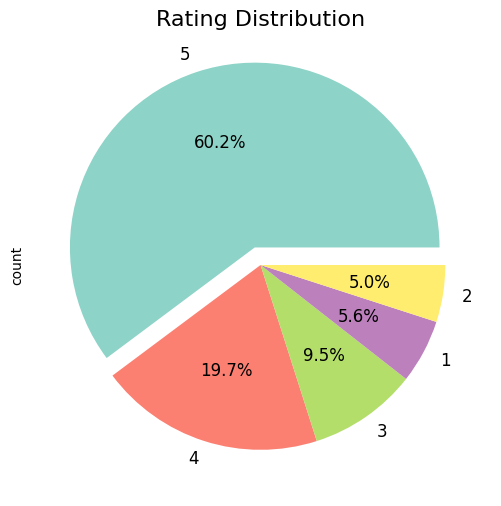

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# for colored piechart
count.plot.pie(autopct ='%1.1f%%' , startangle= 0 , explode=(0.1,0,0,0,0), cmap= 'Set3', fontsize =12)

plt.title("Rating Distribution", fontsize=16)
plt.show()

# **B&W Pie Chart**
# plt.figure(figsize=(6,6))
# count.plot.pie(autopct='%1.1f%%', startangle=0, explode=(0.1,0,0,0,0),
#                colors=['#4B4E53', 'dimgray', 'gray', 'lightgray'],  # Fixed color list
#                wedgeprops={'edgecolor': 'black'})  # Black borders
# plt.title("Rating Distribution", fontsize=16)
# plt.show()


Bar Graph of Original and Fake review

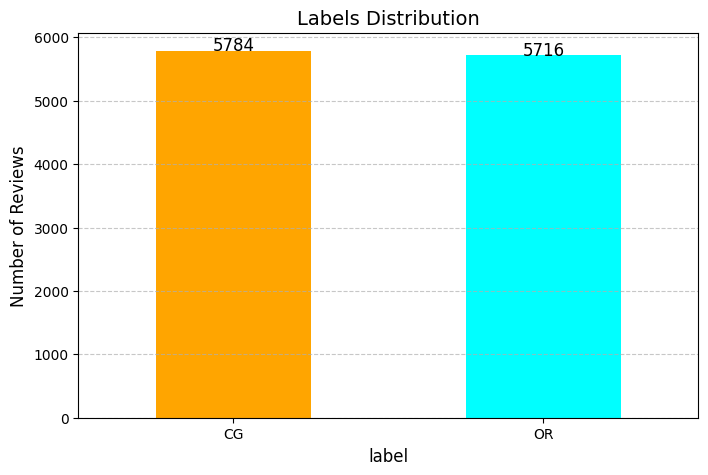

In [7]:
import matplotlib.pyplot as plt

count_label= df['label'].value_counts()
# count_label = pd.Series(count_label)

# Plot bar chart
plt.figure(figsize=(8, 5))

# Add title and labels
plt.title("Labels Distribution", fontsize=14)
plt.xlabel("Fake(CG) vs Real(OR)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

# for colored bargraph
ax = count_label.plot(kind='bar', color=['orange', 'cyan'])

# Add numeric values on bars
for i, v in enumerate(count_label):
    ax.text(i, v + 3, str(v), ha='center', fontsize=12)

# Show the bar chart
plt.xticks(rotation=0)  # Keep category labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

#for black & white bargraph
# plt.figure(figsize=(8, 5))

# # Add title and labels
# plt.title("Labels Distribution", fontsize=14)
# plt.xlabel("Fake(CG) vs Real(OR)", fontsize=12)
# plt.ylabel("Number of Reviews", fontsize=12)
# ax = count_label.plot(kind='bar', color=['dimgray', 'lightgray'])

# # Add numeric values on bars
# for i, v in enumerate(count_label):
#     ax.text(i, v + 3, str(v), ha='center', fontsize=12)

# # Show the bar chart
# plt.xticks(rotation=0)  # Keep category labels horizontal
# plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
# plt.show()


**Preprocessing the dataset**

Converting label to numerical value


In [8]:
df['label'] = df['label'].apply(lambda x: 1 if x == 'OR' else 0)

Converting ratings to string and concatenating them with review text

In [9]:
# # Convert ratings to string and concatenate with review text
# df["combined_text"] = df["rating"].astype(str) + " " + df["Nepali Review"]
# df.head()
df["combined_text"] = "Rating: " + df["rating"].astype(str) + " [SEP] " + df["Nepali Review"]


In [10]:
df.head()

,Nepali Review,rating,label,combined_text
0,मैले यो किन्नुको कारण यही उत्पादन हो। दुई ठूला...,5,0,Rating: 5 [SEP] मैले यो किन्नुको कारण यही उत्प...
1,सजिलो सेटअप भएकोमा धेरै राम्रो लाग्यो। मैले पन...,5,0,Rating: 5 [SEP] सजिलो सेटअप भएकोमा धेरै राम्रो...
2,बिल्कुल सुन्दर स्नान हुकहरू। म यस्तो महँगो स्न...,5,1,Rating: 5 [SEP] बिल्कुल सुन्दर स्नान हुकहरू। म...
3,शैली र ब्लेडले मसँग भएको अन्य उपयोगिता चार्जहर...,5,1,Rating: 5 [SEP] शैली र ब्लेडले मसँग भएको अन्य ...
4,यो फिल्टर प्रणालीले पानी फेरी र क्लीनर राख्छ। ...,5,0,Rating: 5 [SEP] यो फिल्टर प्रणालीले पानी फेरी ...


In [11]:
# X = df[['rating', 'Nepali Review']]
# y = df['label']

In [12]:
# Splitting dataset into train & test sets

from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["combined_text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=1)


from transformers import AutoTokenizer
# Load NepBERT tokenizer
model_name = "NepBERTa/NepBERTa"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/547k [00:00<?, ?B/s]

Convert Data to PyTorch Dataset

In [13]:
import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Convert to PyTorch dataset
train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)


Loading Pre-trained NepBERT Model

In [14]:
from transformers import AutoModelForSequenceClassification

# Load NepBERT with 2 output labels (Fake vs. Real)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, from_tf=True)


tf_model.h5:   0%|          | 0.00/534M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


Model Training

In [15]:
import os
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations with no improvement before stopping
)

# Disable W&B if not using it
os.environ["WANDB_DISABLED"] = "true"

# Define training parameters
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    # learning_rate=5e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=18,
    warmup_steps=250,
    num_train_epochs=6,
    weight_decay=0.001,
    logging_dir="./logs",
    load_best_model_at_end = True,
    # fp16=True,
    gradient_accumulation_steps=32, # Accumulates gradients over 4 steps
     lr_scheduler_type='linear', # Linear learning rate decay
)


# Use Trainer API to fine-tune NepBERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[early_stopping_callback],
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
0,No log,0.640519
1,No log,0.501994
2,No log,0.373316
3,No log,0.589703
4,No log,0.386264
5,No log,0.343574


TrainOutput(global_step=210, training_loss=0.40028577532087056, metrics={'train_runtime': 1428.6604, 'train_samples_per_second': 38.638, 'train_steps_per_second': 0.147, 'total_flos': 3578310352896000.0, 'train_loss': 0.40028577532087056, 'epoch': 5.973913043478261})

Model Evaluation

NepBERTa Model Accuracy: 0.87
Classification Report for NepBERTa:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1152
           1       0.87      0.88      0.87      1148

    accuracy                           0.87      2300
   macro avg       0.87      0.87      0.87      2300
weighted avg       0.87      0.87      0.87      2300



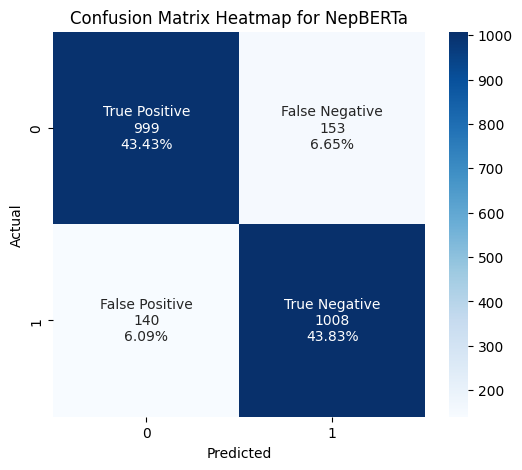

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Get predictions
preds = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1).numpy()

# Compute accuracy
accuracy = accuracy_score(test_labels, pred_labels)
print(f"NepBERTa Model Accuracy: {accuracy:.2f}")
print("Classification Report for NepBERTa:")
print(classification_report(test_labels, pred_labels))

import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix (raw and normalized)
cm_raw = confusion_matrix(test_labels, pred_labels)
cm_norm = confusion_matrix(test_labels, pred_labels, normalize='all')  # Normalize over total samples

# Get the unique class labels
class_names = sorted(list(set(test_labels)))

# Create a formatted annotation matrix (combine raw and percentage values)
labels = np.array([[f"True Positive\n{cm_raw[0,0]}\n{cm_norm[0,0]*100:.2f}%",
                     f"False Negative\n{cm_raw[0,1]}\n{cm_norm[0,1]*100:.2f}%"],
                   [f"False Positive\n{cm_raw[1,0]}\n{cm_norm[1,0]*100:.2f}%",
                     f"True Negative\n{cm_raw[1,1]}\n{cm_norm[1,1]*100:.2f}%"]])

# Create a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_raw, annot=labels, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap for NepBERTa')
plt.show()


**Save and Test the Model**

Using "save_pretrained" which is the preferred Hugging Face's method

In [17]:
# Save model using Hugging Face's method
model.save_pretrained("./fine_tuned_nepbert")

# Load model using Hugging Face's method
# from transformers import BertForSequenceClassification, BertTokenizer
# model = BertForSequenceClassification.from_pretrained("./fine_tuned_nepbert")
# tokenizer = BertTokenizer.from_pretrained("./fine_tuned_nepbert")


Using pickle

In [18]:
# import pickle

# # Save the model to a pickle file
# with open("nepbert_model.pkl", "wb") as f:
#     pickle.dump(model, f)


Checking Model output

In [19]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./fine_tuned_nepbert", tokenizer=tokenizer)
# or
# Load model using Hugging Face's method
# from transformers import BertForSequenceClassification, BertTokenizer
# model = BertForSequenceClassification.from_pretrained("./fine_tuned_nepbert")
# tokenizer = BertTokenizer.from_pretrained("./fine_tuned_nepbert")


Device set to use cuda:0


In [20]:
# Example rating and review
rating = 1
review = "यो होटल ठगि हो।"  # Example Nepali review

# Concatenate rating with review (same format as training)
input_text = f"{rating} [SEP]{review}"

# Get prediction
result = classifier(input_text)

# print(result) #gives following o/p
# [{'label': 'LABEL_0', 'score': 0.9900834560394287}]

# Extract label and confidence score
label = result[0]['label']
score = result[0]['score'] * 100  # Convert to percentage

# Interpret the label (assuming LABEL_0 = Fake, LABEL_1 = Real)
label_text = "Fake" if label == "LABEL_0" else "Real"

# Display output
print(f"Review is {label_text} with {score:.2f}% accuracy.")


Review is Fake with 56.79% accuracy.


In [21]:
# Example rating and review
rating = 5
review = "यो होटल ठगि हो।"  # Example Nepali review

# Concatenate rating with review (same format as training)
input_text = f"Rating: {rating} [SEP] {review}"

# Get prediction
result = classifier(input_text)

# print(result) #gives following o/p
# [{'label': 'LABEL_0', 'score': 0.9900834560394287}]

# Extract label and confidence score
label = result[0]['label']
score = result[0]['score'] * 100  # Convert to percentage

# Interpret the label (assuming LABEL_0 = Fake, LABEL_1 = Real)
label_text = "Fake" if label == "LABEL_0" else "Real"

# Display output
print(f"Review is {label_text} with {score:.2f}% accuracy.")


Review is Real with 89.63% accuracy.


In [22]:
# Example rating and review
rating = 5
review = "यसले मेरो फोनलाई चार्जर पूर्ण रूपमा चार्ज भएपछि मात्र चार्ज गर्न अनुमति दिन्छ। यसको एक मात्र नकारात्मक पक्ष भनेको जब तपाईं"

# Concatenate rating with review (same format as training)
input_text = f"Rating: {rating} [SEP] {review}"

# Get prediction
result = classifier(input_text)

# Extract label and confidence score
label = result[0]['label']
score = result[0]['score'] * 100  # Convert to percentage

# Interpret the label (assuming LABEL_0 = Fake, LABEL_1 = Real)
label_text = "Fake" if label == "LABEL_0" else "Real"

# Display output
print(f"Review is {label_text} with {score:.2f}% accuracy.")


Review is Fake with 98.43% accuracy.


In [23]:
# Example rating and review
rating = 1
review = "यसले मेरो फोनलाई चार्जर पूर्ण रूपमा चार्ज भएपछि मात्र चार्ज गर्न अनुमति दिन्छ। यसको एक मात्र नकारात्मक पक्ष भनेको जब तपाईं"

# Concatenate rating with review (same format as training)
input_text = f"Rating: {rating}[SEP]{review}"

# Get prediction
result = classifier(input_text)

# Extract label and confidence score
label = result[0]['label']
score = result[0]['score'] * 100  # Convert to percentage

# Interpret the label (assuming LABEL_0 = Fake, LABEL_1 = Real)
label_text = "Fake" if label == "LABEL_0" else "Real"

# Display output
print(f"Review is {label_text} with {score:.2f}% accuracy.")

Review is Fake with 98.38% accuracy.
